# Tools

In [94]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from google.cloud import bigquery
import time
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import seaborn as sns
import simplejson as json
import os
from datetime import timedelta
import webbrowser
import papermill as pm
from enum import Enum
import re
import simplejson as json
from IPython.core.interactiveshell import InteractiveShell
from sklearn.ensemble import IsolationForest
from collections import Counter

In [95]:
# InteractiveShell.ast_node_interactivity = "all"
%env GOOGLE_APPLICATION_CREDENTIALS=./secrets/bigquery-service-account.json
client = bigquery.Client()

env: GOOGLE_APPLICATION_CREDENTIALS=./secrets/bigquery-service-account.json


# Configuration

In [96]:
max_number_of_clusters = 30
min_number_of_clusters = 3

# todo
class OUTLIER_REMOVAL(Enum):
    NONE = 1 
    VARIANCE_THRESHOLD_WITHIN_CLUSTER = 2 
    ISOLATION_FOREST = 3 

outlier_removal = OUTLIER_REMOVAL.NONE.value

In [97]:
number_of_addresses = 40000

# format: dd.mm.yyyy
observation_period_start = "2019-09-01 00:00:00+00"
observation_period_end = "2020-02-01 00:00:00+00"

class ADDRESS_SELECTION(Enum):
    RANDOM = 1 # selects random features.index, that have been active within the observation period.
    RICHEST = 2 # selects the accounts that have the most ether # not yet implemented
    HIGHEST_TURNOVER = 3 # selects the accounts that have the most ether received + sent

address_selection = ADDRESS_SELECTION.HIGHEST_TURNOVER.value

# max USD amount to spent for executing sql queries
max_bigquery_costs_usd = 2

# Delete existing tables
reset = False

# Create feature table in bigquery

In [98]:
try:
    pm.execute_notebook(
       './bigquery/features.ipynb',
       './bigquery/build/features.build.ipynb',
       parameters = dict(number_of_addresses=number_of_addresses, observation_period_start=observation_period_start,observation_period_end=observation_period_end, address_selection=address_selection,max_bigquery_costs_usd=max_bigquery_costs_usd, reset = reset),
       cwd = "./bigquery"
    )
except Exception as e:
    if "does already exist" in e.args[0]:
        print("Feature table does already exist.")
        pass
    else:
        raise

# Load feature table from bigquery

In [99]:
table_name = "features"
table_id = "{}_{}_{}_{}_{}".format(table_name, ADDRESS_SELECTION(address_selection).name, number_of_addresses, re.sub(r'[-.+: ]', '_', observation_period_start),re.sub(r'[-.+: ]', '_', observation_period_end))

filename = '{}.json'.format(table_id)
data_dir = "./data"

if filename not in os.listdir("./data") or reset == True:
     
    print("Loading data from bigquery ...")
    
    sql = """
        SELECT *
        FROM `masterarbeit-245718.ethereum_us.{table_id_features}` 
        """.format(table_id_features = table_id)

    query_job = client.query(sql)  
    
    start = time.time();
    
    features = query_job.result().to_dataframe(); 
    features = features.set_index("address")
    
    done = time.time();
    elapsed = round(done - start);
    
    print("Time to retrieve data from BigQuery: {} Minutes.".format(round(elapsed/60)))
    
    with open('{}/{}'.format(data_dir, filename), 'w') as json_file:
        json.dump(features.to_dict(), json_file, use_decimal=True, default=str)
        
else: 
    
    print("Loading data from local cache ...")
    
    start = time.time();
    
    with open('./data/{}'.format(filename), "r") as file:  
        file_content_json = json.load(file);
        
    done = time.time();
    elapsed = round(done - start);
    
    features = pd.DataFrame(file_content_json) 
    
    print("Time to retrieve data from local cache: {} Seconds.".format(elapsed))
        

Loading data from bigquery ...
Time to retrieve data from BigQuery: 0 Minutes.


In [100]:
m = features.memory_usage();
total_bytes = m.sum();
total_megabytes = total_bytes/10**6;
print("Size of the account feature dataset: {} Megabytes.".format(round(total_megabytes)))

Size of the account feature dataset: 9.0 Megabytes.


In [101]:
features.head()

,wei_received,wei_sent,balance,number_of_tx_received,number_of_tx_sent,avg_time_diff_received_tx,avg_time_diff_sent_tx,mined_blocks,stddev_received_tx,stddev_sent_tx,...,avg_usd_received,monthly_wei_sent,monthly_wei_received,monthly_usd_sent,monthly_usd_received,monthly_outgoing_txns,monthly_incoming_txns,number_of_contracts_created,contract_tx,diff_token_used
address,,,,,,,,,,,,,,,,,,,,,
0xd7af3a34d98865506ca690d564ab4e35455a5741,0,1226500000000000000000,-1226500000000000000000,0,2,0.0,1.214551e+06,0,0.0,0.000000,...,0.0,1226500000000000000000,0,2.160986e+05,0.0,2.0,0.0,0,0,0
0xbbebcc1f7f7e901a6c1ed6246d90fc458d66caca,0,699809548500000000000,-699809548500000000000,0,2,0.0,3.448000e+03,0,0.0,0.000000,...,0.0,699809548500000000000,0,9.285073e+04,0.0,2.0,0.0,0,0,0
0xdfa8a0221e9d4b0df228986419551a2f4ba1dc60,0,600000000000000000000,-600000000000000000000,0,2,0.0,1.109610e+05,0,0.0,0.000000,...,0.0,600000000000000000000,0,1.001490e+05,0.0,2.0,0.0,0,0,0
0xa2bf029e9d903cef68fd5943ab0cb9cf5570c4ac,0,6836099439820000000911,-6836099439820000000911,0,2,0.0,8.400000e+01,0,0.0,0.000000,...,0.0,6836099439820000000911,0,1.510846e+06,0.0,2.0,0.0,0,0,0
0xca2ed53c58de702591fe74c3f8f1e4849d66d88a,0,1000000000000000000000,-1000000000000000000000,0,4,0.0,2.865873e+05,0,0.0,142636.750174,...,0.0,500000000000000000000,0,8.784625e+04,0.0,2.0,0.0,0,0,0


# Set avg_time_diff and stddev 0 values to max

In [102]:
features["avg_time_diff_sent_tx"] = features["avg_time_diff_sent_tx"].replace(to_replace=0.0, value=max(features["avg_time_diff_sent_tx"]))
features["avg_time_diff_received_tx"] = features["avg_time_diff_received_tx"].replace(to_replace=0.0, value=max(features["avg_time_diff_received_tx"]))

In [103]:
features["stddev_received_tx"] = features["stddev_received_tx"].replace(to_replace=0.0, value=max(features["stddev_received_tx"]))
features["stddev_sent_tx"] = features["stddev_sent_tx"].replace(to_replace=0.0, value=max(features["stddev_sent_tx"]))

# Standardise feature values, so that all feature values have the same mean and stddev

In [104]:
scaler = StandardScaler(copy=True, with_mean=True, with_std=True);
features_std = scaler.fit_transform(features);
features_std = pd.DataFrame(features_std, columns=features.columns, index=features.index);

# Use Isolationforest to remove outliers

In [105]:
clf = IsolationForest(max_samples="auto", behaviour='new', contamination=0.01)

clf.fit(features_std)
pred = clf.predict(features_std)

features_clean = features[pred == 1]
features_std_clean = features_std[pred == 1]

outliers = features[pred == -1]

print("Number of detected outliers: {}".format(outliers.shape[0]))

Number of detected outliers: 400


In [106]:
# order by turnover 
outliers_tmp = outliers.copy()
outliers_tmp["turnover"] = outliers["wei_received"] + outliers["wei_sent"]
outliers_tmp["balance"] = outliers["wei_received"] - outliers["wei_sent"]
outliers_tmp = outliers_tmp.sort_values(by=["turnover"], ascending=False)
outliers_tmp.head()

,wei_received,wei_sent,balance,number_of_tx_received,number_of_tx_sent,avg_time_diff_received_tx,avg_time_diff_sent_tx,mined_blocks,stddev_received_tx,stddev_sent_tx,...,monthly_wei_sent,monthly_wei_received,monthly_usd_sent,monthly_usd_received,monthly_outgoing_txns,monthly_incoming_txns,number_of_contracts_created,contract_tx,diff_token_used,turnover
address,,,,,,,,,,,,,,,,,,,,,
0x3f5ce5fbfe3e9af3971dd833d26ba9b5c936f0be,11329252155535834171833497,11218404798936185645211577,110847356599648526621920,428837,314966,30.822655,41.969882,0,173.850942,71.013877,...,2243680959787237129042315.4,2265850431107166834366699.4,3.768385e+08,3.803555e+08,62993.20,85767.40,0,225013,127,22547656954472019817045074
0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,6736326237841738290677133,5706510426813962971936808,1029815811027775318740325,2579724,377228,5.124202,35.042603,0,17.124761,74.238789,...,1141302085362792594387361.6,1347265247568347658135426.6,1.808443e+08,2.138769e+08,75445.60,515944.80,0,0,0,12442836664655701262613941
0xa7efae728d2936e78bda97dc267687568dd593f3,4007359259697374000000000,3792572311000000000000000,214786948697374000000000,88853,43717,108.718611,221.012307,0,619.408527,594.042406,...,948143077750000000000000,1001839814924343500000000,1.521163e+08,1.610895e+08,10929.25,22213.25,0,0,0,7799931570697374000000000
0x267be1c1d684f78cb4f6a176c4911b741e4ffdc0,2728917736118778625468861,2817659185849405400000000,-88741449730626774531139,110388,54919,119.751357,240.703831,0,154.378154,352.212792,...,563531837169881080000000,545783547223755725093772.2,9.361118e+07,8.980717e+07,10983.80,22077.60,0,0,0,5546576921968184025468861
0xfa52274dd61e1643d2205169732f29114bc240b3,2728915396568188709223010,2728915396568188709223010,0,110377,110377,119.763291,119.763291,0,154.392573,154.392573,...,545783079313637741844602,545783079313637741844602,8.980711e+07,8.980711e+07,22075.40,22075.40,0,0,0,5457830793136377418446020


In [107]:
# # opens outliers features.index via etherscan
# n = 5 # first n features.index get opened
# i = 0
# for address, features in outliers_tmp.iterrows():
#     webbrowser.open('https://etherscan.io/address/{}'.format(address), new=2)
#     i += 1
#     if i == n:
#         break

# Via Principal Component Analyse die Anzahl der Dimensionen der Datenpunkten für das k-means Clustering Verfahren minimieren 

**Frage:** Wie viel Varianz sollte von der Teilmenge der Principal Components, welche die meiste Varianz erklären, mindestens erklärt werden? Im Folgenden treffe ich die Annahme, dass 90% ausreicht.

In [108]:
min_explained_variance = 0.9

In [109]:
pca = PCA().fit(features_std)
optimal_number_of_clusters = 0
for i in np.cumsum(pca.explained_variance_ratio_):
    optimal_number_of_clusters = optimal_number_of_clusters + 1
    if i > min_explained_variance:
        break;

print("Die {} ersten PCA-Komponenten erklären mehr als {}% der Varianz.".format(optimal_number_of_clusters, min_explained_variance*100))

Die 9 ersten PCA-Komponenten erklären mehr als 90.0% der Varianz.


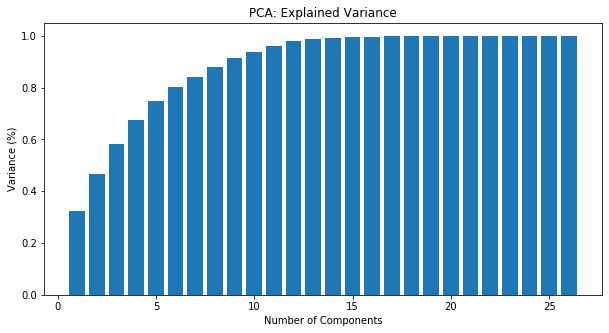

In [110]:
plt.figure(figsize=(10,5))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1, 1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('PCA: Explained Variance')
plt.show()

In [111]:
pca = PCA(n_components=optimal_number_of_clusters);
features_std_pca = pca.fit_transform(features_std);
features_std_pca = pd.DataFrame(features_std_pca);
features_std_pca.index = features.index
features_std_pca.head()

,0,1,2,3,4,5,6,7,8
address,,,,,,,,,
0xd7af3a34d98865506ca690d564ab4e35455a5741,-0.313723,2.348370,0.507040,-0.940980,-0.647264,-0.050694,0.054745,0.064199,-0.028107
0xbbebcc1f7f7e901a6c1ed6246d90fc458d66caca,-0.342846,2.212375,0.494565,-0.995050,-0.583798,-0.076284,0.049118,0.066418,-0.016559
0xdfa8a0221e9d4b0df228986419551a2f4ba1dc60,-0.344076,2.219783,0.497200,-1.004597,-0.581007,-0.076732,0.049762,0.066488,-0.017527
0xa2bf029e9d903cef68fd5943ab0cb9cf5570c4ac,0.021300,2.605929,0.370982,0.107750,-1.124069,0.188397,0.011203,-0.025341,-0.012486
0xca2ed53c58de702591fe74c3f8f1e4849d66d88a,-0.305932,1.010730,0.231071,-0.540015,-0.356802,-0.085835,0.039449,0.094793,-0.018191


# Die Anzahl der Cluster bestimmen

In [112]:
def estimateNumberOfClusters(features, features_std_pca, max_number_of_clusters):
    scores = []
    numberOfCluster = []

    for i in range(2,max_number_of_clusters,1):
        kmeans_tmp = KMeans(n_clusters=i)
        kmeans_tmp.fit(features_std_pca)
        numberOfCluster.append(i)
        scores.append(metrics.calinski_harabasz_score(features, kmeans_tmp.labels_))  
    
    result = pd.DataFrame(np.transpose(np.array([numberOfCluster, scores])).astype(int), columns=["Number of Clusters", "C.H. Score"]);
    optimal_number_of_clusters = numberOfCluster[np.argmax(scores)];
    
    return result, optimal_number_of_clusters;

In [113]:
def plotScores(scores):
    plt.figure()
    plt.bar(scores.iloc[:, 0],scores.iloc[:, 1] )
    plt.xlabel('Number of Clusters')
    plt.ylabel('C.H. Score') #for each component
    plt.title('Calinski Harabasz Score')
    plt.show()

In [114]:
scores = []
numberOfCluster = []

# 3 clusters are not considered to be valid
for i in range(min_number_of_clusters, max_number_of_clusters, 1):
    kmeans_tmp = KMeans(n_clusters=i)
    kmeans_tmp.fit(features_std_pca)
    numberOfCluster.append(i)
    scores.append(metrics.calinski_harabasz_score(features, kmeans_tmp.labels_))  

results = pd.DataFrame(zip(numberOfCluster, scores), columns=["number_of_clusters", "calinski_score"])
optimal_number_of_clusters = results.loc[results["calinski_score"].idxmax()].astype(int)["number_of_clusters"]

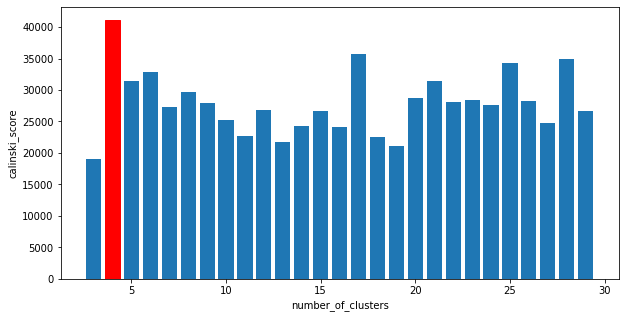

The optimal number of clusters is 4.


In [115]:
plt.figure(figsize=(10,5))
bars = plt.bar(x=results["number_of_clusters"], height=results["calinski_score"])
plt.xlabel(results.columns[0])
plt.ylabel(results.columns[1]) 
bars[results["calinski_score"].idxmax()].set_color("r")
plt.show()
plt.close()
print("The optimal number of clusters is {}.".format(optimal_number_of_clusters))

In [116]:
#  optimal_number_of_clusters = 5 # tmp

# Outlier removal

**Todo**: *Prüfen in wie weit hierdurch wie bei Isolation Forest die exchange features.index rausgehauen werden.*

In [117]:
# def remove_outliers(features, features_std_pca, kmeans, threshold):
    
#     features_std_pca_within_cluster_new = pd.DataFrame();
#     features_within_cluster_new = pd.DataFrame();
#     labels_new = [];

#     for clusterNumber, centroid in enumerate(kmeans.cluster_centers_):
        
#         features_std_pca_within_cluster = features_std_pca[kmeans_opt.labels_ == clusterNumber];
#         features_within_cluster = features[kmeans_opt.labels_ == clusterNumber];
            
#         distances = features_std_pca_within_cluster - centroid;
#         distances_norm = np.linalg.norm(distances, axis=1);

#         maxDistance = threshold * np.linalg.norm(features_std_pca_within_cluster.std())
        
#         keep = distances_norm <= maxDistance
        
#         features_std_pca_within_cluster_new = features_std_pca_within_cluster_new.append(features_std_pca_within_cluster[keep])
#         features_within_cluster_new = features_within_cluster_new.append(features_within_cluster[keep])
#         labels_new.extend([clusterNumber for i in features_within_cluster[keep].iterrows()])
        
#     return features_std_pca_within_cluster_new, features_within_cluster_new, labels_new

In [118]:
# kmeans_opt = KMeans(n_clusters=optimal_number_of_clusters)
# kmeans_opt.fit(features_std_pca)

In [119]:
# from sklearn.metrics import calinski_harabaz_score as ch_score

# thresholds = np.linspace(.01,3, 20)

# test = [remove_outliers(features, features_std_pca, kmeans_opt,t) for t in thresholds]

# scores= []

# for (res1, res2, labels) in test:
#     scores.append(metrics.calinski_harabasz_score(res2, labels)) 

In [120]:
# plt.plot(thresholds, scores)
# plt.title('Calinski Harabaz Scores as std threshold changes')

In [121]:
# optimalThreshold = thresholds[np.argmax(scores)]
# print("The threshold leading to the highest Calinski Harabaz Score is", optimalThreshold)

In [122]:
# features, features_std_pca, labels = remove_outliers(features, features_std_pca, kmeans_opt, optimalThreshold)
# features_std_pca = pd.DataFrame(features_std_pca)
# features = pd.DataFrame(features)

# Visualisierung: T-SNE

In [123]:
# from sklearn.manifold import TSNE

# time_start = time.time()

# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
# features_std_pca_out_tsne = tsne.fit_transform(features_std_pca_out)
# features_std_pca_out_tsne = pd.DataFrame(features_std_pca_out_tsne, columns=["1_tsne_comp","1_tsne_comp"])
# features_std_pca_out_tsne.head()

# print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [124]:
# # Plot Digits t-SNE
# import seaborn as sns

# # Set style of scatterplot
# sns.set_context("notebook", font_scale=1.1)
# sns.set_style("ticks")

# features_std_pca_out_tsne["Label"] = kmeans_opt.labels_
# features_std_pca_out_tsne.columns = ["x", "y", "Label"]

# sns.lmplot(x='x',
#            y='y',
#            data=features_std_pca_out_tsne,
#            fit_reg=False,
#            legend=True,
#            height=9,
#            hue='Label',
#            scatter_kws={"s":200, "alpha":0.3})


# plt.title('t-SNE Results:', weight='bold').set_fontsize('14')
# plt.xlabel('Prin Comp 1', weight='bold').set_fontsize('10')
# plt.ylabel('Prin Comp 2', weight='bold').set_fontsize('10')

# Clustering

In [125]:
kmeans_opt = KMeans(n_clusters=optimal_number_of_clusters)
kmeans_opt.fit(features_std_pca)

features["label"] = kmeans_opt.labels_

# Cluster data

In [126]:
clusters = dict() 
labels = features["label"].unique()
labels.sort()

for label in labels:
    cluster_name = 'cluster_{}'.format(label)
    
    features_in_cluster = features[features.label == label]
    
    clusters[cluster_name] = dict()
    clusters[cluster_name]["number_of_addresses"] = Counter(features["label"])[label]
    clusters[cluster_name]["feature_means"] = features_in_cluster.drop(columns=["label"]).mean()
    
feature_means = pd.DataFrame(columns = clusters[cluster_name]['feature_means'].keys())

for key in clusters:
    clusters[key]["feature_means"].name = key
    feature_means = feature_means.append(clusters[key]["feature_means"])

# Display cluster means (via table)

In [127]:
feature_means_display = feature_means.round()

feature_means_display["eth_received"] = feature_means_display["wei_received"] / 10**18
feature_means_display["eth_sent"] = feature_means_display["wei_sent"] / 10**18
feature_means_display["eth_balance"] = feature_means_display["balance"] / 10**18
feature_means_display["avg_eth_sent"] = feature_means_display["avg_wei_sent"] / 10**18
feature_means_display["avg_eth_received"] = feature_means_display["avg_wei_received"] / 10**18
feature_means_display["monthly_eth_sent"] = feature_means_display["monthly_wei_sent"] / 10**18
feature_means_display["monthly_eth_received"] = feature_means_display["monthly_wei_received"] / 10**18

feature_means_display = feature_means_display.drop(columns=["wei_received"])
feature_means_display = feature_means_display.drop(columns=["wei_sent"])
feature_means_display = feature_means_display.drop(columns=["balance"])
feature_means_display = feature_means_display.drop(columns=["avg_wei_sent"])
feature_means_display = feature_means_display.drop(columns=["avg_wei_received"])
feature_means_display = feature_means_display.drop(columns=["monthly_wei_sent"])
feature_means_display = feature_means_display.drop(columns=["monthly_wei_received"])

feature_means_display["number_of_addresses"] = [clusters[c]["number_of_addresses"] for c in clusters]

cols = list(feature_means_display.columns.values) 
cols.pop(cols.index('number_of_addresses')) 
cols.pop(cols.index('eth_balance')) 
cols.pop(cols.index('eth_sent')) 
cols.pop(cols.index('eth_received')) 
feature_means_display = feature_means_display[["number_of_addresses", "eth_balance", "eth_sent", "eth_received"]+cols] 


if len(feature_means_display.columns) > len(feature_means_display.index):
    print("Number of Addresses: {}".format(number_of_addresses))
    print("Observation-Period: {} to {}".format(observation_period_start, observation_period_end))
    display(feature_means_display.T.astype("int"))
else:
    display(feature_means_display.astype("int"))

Number of Addresses: 40000
Observation-Period: 2019-09-01 00:00:00+00 to 2020-02-01 00:00:00+00


,cluster_0,cluster_1,cluster_2,cluster_3
number_of_addresses,28613,2,11312,73
eth_balance,63,570331,160,-43288
eth_sent,4458,8462457,2038,1091245
eth_received,4521,9032789,2199,1047956
number_of_tx_received,747,1504280,10,50016
number_of_tx_sent,1581,346097,4,335358
avg_time_diff_received_tx,514737,18,9319759,880482
avg_time_diff_sent_tx,455537,39,8836898,959568
mined_blocks,17,0,0,7014
stddev_received_tx,916467,95,7991225,880938


## Display principal components

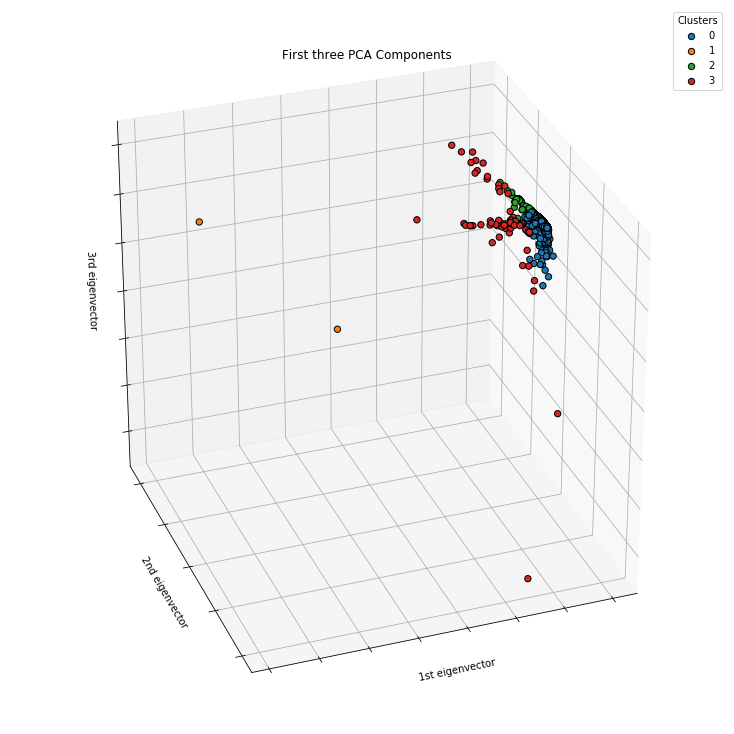

In [128]:
from mpl_toolkits.mplot3d import Axes3D;

fig = plt.figure(figsize=(10, 10));
ax = Axes3D(fig, elev=-150, azim=110);

pca_tmp = PCA(n_components=3)
features_std_pca_tmp = pca_tmp.fit_transform(features_std);
features_std_pca_tmp = pd.DataFrame(features_std_pca_tmp)
features_std_pca_tmp.index = features.index 
features_std_pca_tmp.columns = ["1st eigenvector", "2st eigenvector", "3st eigenvector"] 
features_std_pca_tmp["label"] = features["label"]

labels = np.sort(features_std_pca_tmp.label.unique())

for l in labels:
    ax.scatter(features_std_pca_tmp["1st eigenvector"][features_std_pca_tmp["label"] == l], 
           features_std_pca_tmp["2st eigenvector"][features_std_pca_tmp["label"] == l],
           features_std_pca_tmp["3st eigenvector"][features_std_pca_tmp["label"] == l],
           label = l, 
           edgecolor='k', s=40, alpha = 1);

ax.set_title("First three PCA Components");
ax.set_xlabel("1st eigenvector");
ax.w_xaxis.set_ticklabels([]);
ax.set_ylabel("2nd eigenvector");
ax.w_yaxis.set_ticklabels([]);
ax.set_zlabel("3rd eigenvector");
ax.w_zaxis.set_ticklabels([]);
ax.legend(title= "Clusters")

In [129]:
# fig, ax = plt.subplots(figsize= (20,10))

# scaler = StandardScaler(copy=True, with_mean=True, with_std=True);
# features_std = scaler.fit_transform(features);
# features_std = pd.DataFrame(features_std, columns=features.columns);
# X_reduced = PCA(n_components=2).fit_transform(features_std);

# ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=kmeans_opt.labels_)
# ax.set_xlabel("Principal Component 1")
# ax.set_ylabel("Principal Component 2")
# pd.Series(kmeans_opt.labels_).unique()

In [130]:
# features_std_pca_tmp.idxmax()

In [131]:
# snowflakes = features_std_pca_tmp.idxmax()
# snowflakes
# for i in snowflakes:
#     print(features.index[i])

# Display Cluster means (via radar plots)

In [132]:
# cluster_data_for_plot1 = cluster_data.drop(columns=["cluster_size"])
# cluster_data_for_plot1 = cluster_data_for_plot1 / cluster_data_for_plot1.sum()
# cluster_data_for_plot1["cluster_size"] = cluster_data["cluster_size"]
# # cluster_data_for_plot1 = cluster_data_for_plot1.reset_index()

# ax = cluster_data_for_plot1.plot.barh(x="cluster_size" ,figsize=(15,15))

# ax.tick_params(
#     which="major",
#     axis='x', 
#     bottom=False
#     )

# ax.tick_params(
#     which="major",
#     axis='y', 
#     labelsize=15
#     ) 

# ylabels = ax.get_yticklabels()

# ax.legend(loc="lower right", fontsize="larger")

# ax.set_xticklabels([])
# ylabel = ax.set_ylabel("Size of\nCluster", fontsize="xx-large", rotation=0, labelpad=60)

In [140]:
features_std.describe()

,wei_received,wei_sent,balance,number_of_tx_received,number_of_tx_sent,avg_time_diff_received_tx,avg_time_diff_sent_tx,mined_blocks,stddev_received_tx,stddev_sent_tx,...,avg_usd_received,monthly_wei_sent,monthly_wei_received,monthly_usd_sent,monthly_usd_received,monthly_outgoing_txns,monthly_incoming_txns,number_of_contracts_created,contract_tx,diff_token_used
count,4.000000e+04,4.000000e+04,4.000000e+04,4.000000e+04,4.000000e+04,4.000000e+04,4.000000e+04,4.000000e+04,4.000000e+04,4.000000e+04,...,4.000000e+04,4.000000e+04,4.000000e+04,4.000000e+04,40000.000000,4.000000e+04,4.000000e+04,4.000000e+04,4.000000e+04,4.000000e+04
mean,5.684342e-18,-8.526513e-18,1.421085e-18,-8.526513e-18,-5.684342e-18,-1.023182e-16,-6.821210e-17,-1.421085e-18,-9.094947e-17,9.094947e-17,...,1.136868e-17,-1.136868e-17,-7.105427e-18,7.105427e-18,0.000000,1.421085e-18,-2.842171e-18,3.819167e-18,-2.842171e-18,-5.684342e-18
std,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,...,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00
min,-6.997621e-02,-7.139994e-02,-5.534736e+01,-4.165141e-02,-2.907583e-02,-6.045215e-01,-5.761895e-01,-1.236563e-02,-7.805136e-01,-7.196594e-01,...,-1.382286e-01,-1.074555e-01,-1.047877e-01,-1.068348e-01,-0.104617,-1.982042e-02,-4.863001e-02,-9.123835e-03,-2.468741e-02,-1.343184e-01
25%,-6.557709e-02,-6.687226e-02,-2.811646e-03,-4.153304e-02,-2.902631e-02,-5.934856e-01,-5.669222e-01,-1.236563e-02,-7.457497e-01,-6.894170e-01,...,-1.341089e-01,-9.924802e-02,-9.679904e-02,-9.863850e-02,-0.096593,-1.976259e-02,-4.835317e-02,-9.123835e-03,-2.468741e-02,-1.343184e-01
50%,-6.266412e-02,-6.388883e-02,-2.811396e-03,-4.117792e-02,-2.891076e-02,-5.402131e-01,-5.200087e-01,-1.236563e-02,-6.065104e-01,-5.819493e-01,...,-1.186301e-01,-8.901355e-02,-8.675405e-02,-8.866619e-02,-0.086765,-1.964050e-02,-4.763339e-02,-9.123835e-03,-2.468741e-02,-1.343184e-01
75%,-5.287901e-02,-5.364331e-02,-2.806437e-03,-3.934315e-02,-2.818447e-02,-1.900003e-01,-2.275824e-01,-1.236563e-02,1.558813e+00,1.693753e+00,...,-5.602154e-02,-6.366671e-02,-6.198103e-02,-6.376094e-02,-0.062213,-1.916501e-02,-4.516952e-02,-9.123835e-03,-2.451477e-02,-6.587155e-02
max,1.273759e+02,1.295309e+02,7.254829e+01,1.526421e+02,1.529843e+02,1.945433e+00,2.055565e+00,1.478924e+02,1.558813e+00,1.693753e+00,...,1.016791e+02,1.185106e+02,1.169795e+02,1.194099e+02,118.341922,1.786736e+02,1.427851e+02,1.419079e+02,1.555598e+02,1.226594e+02


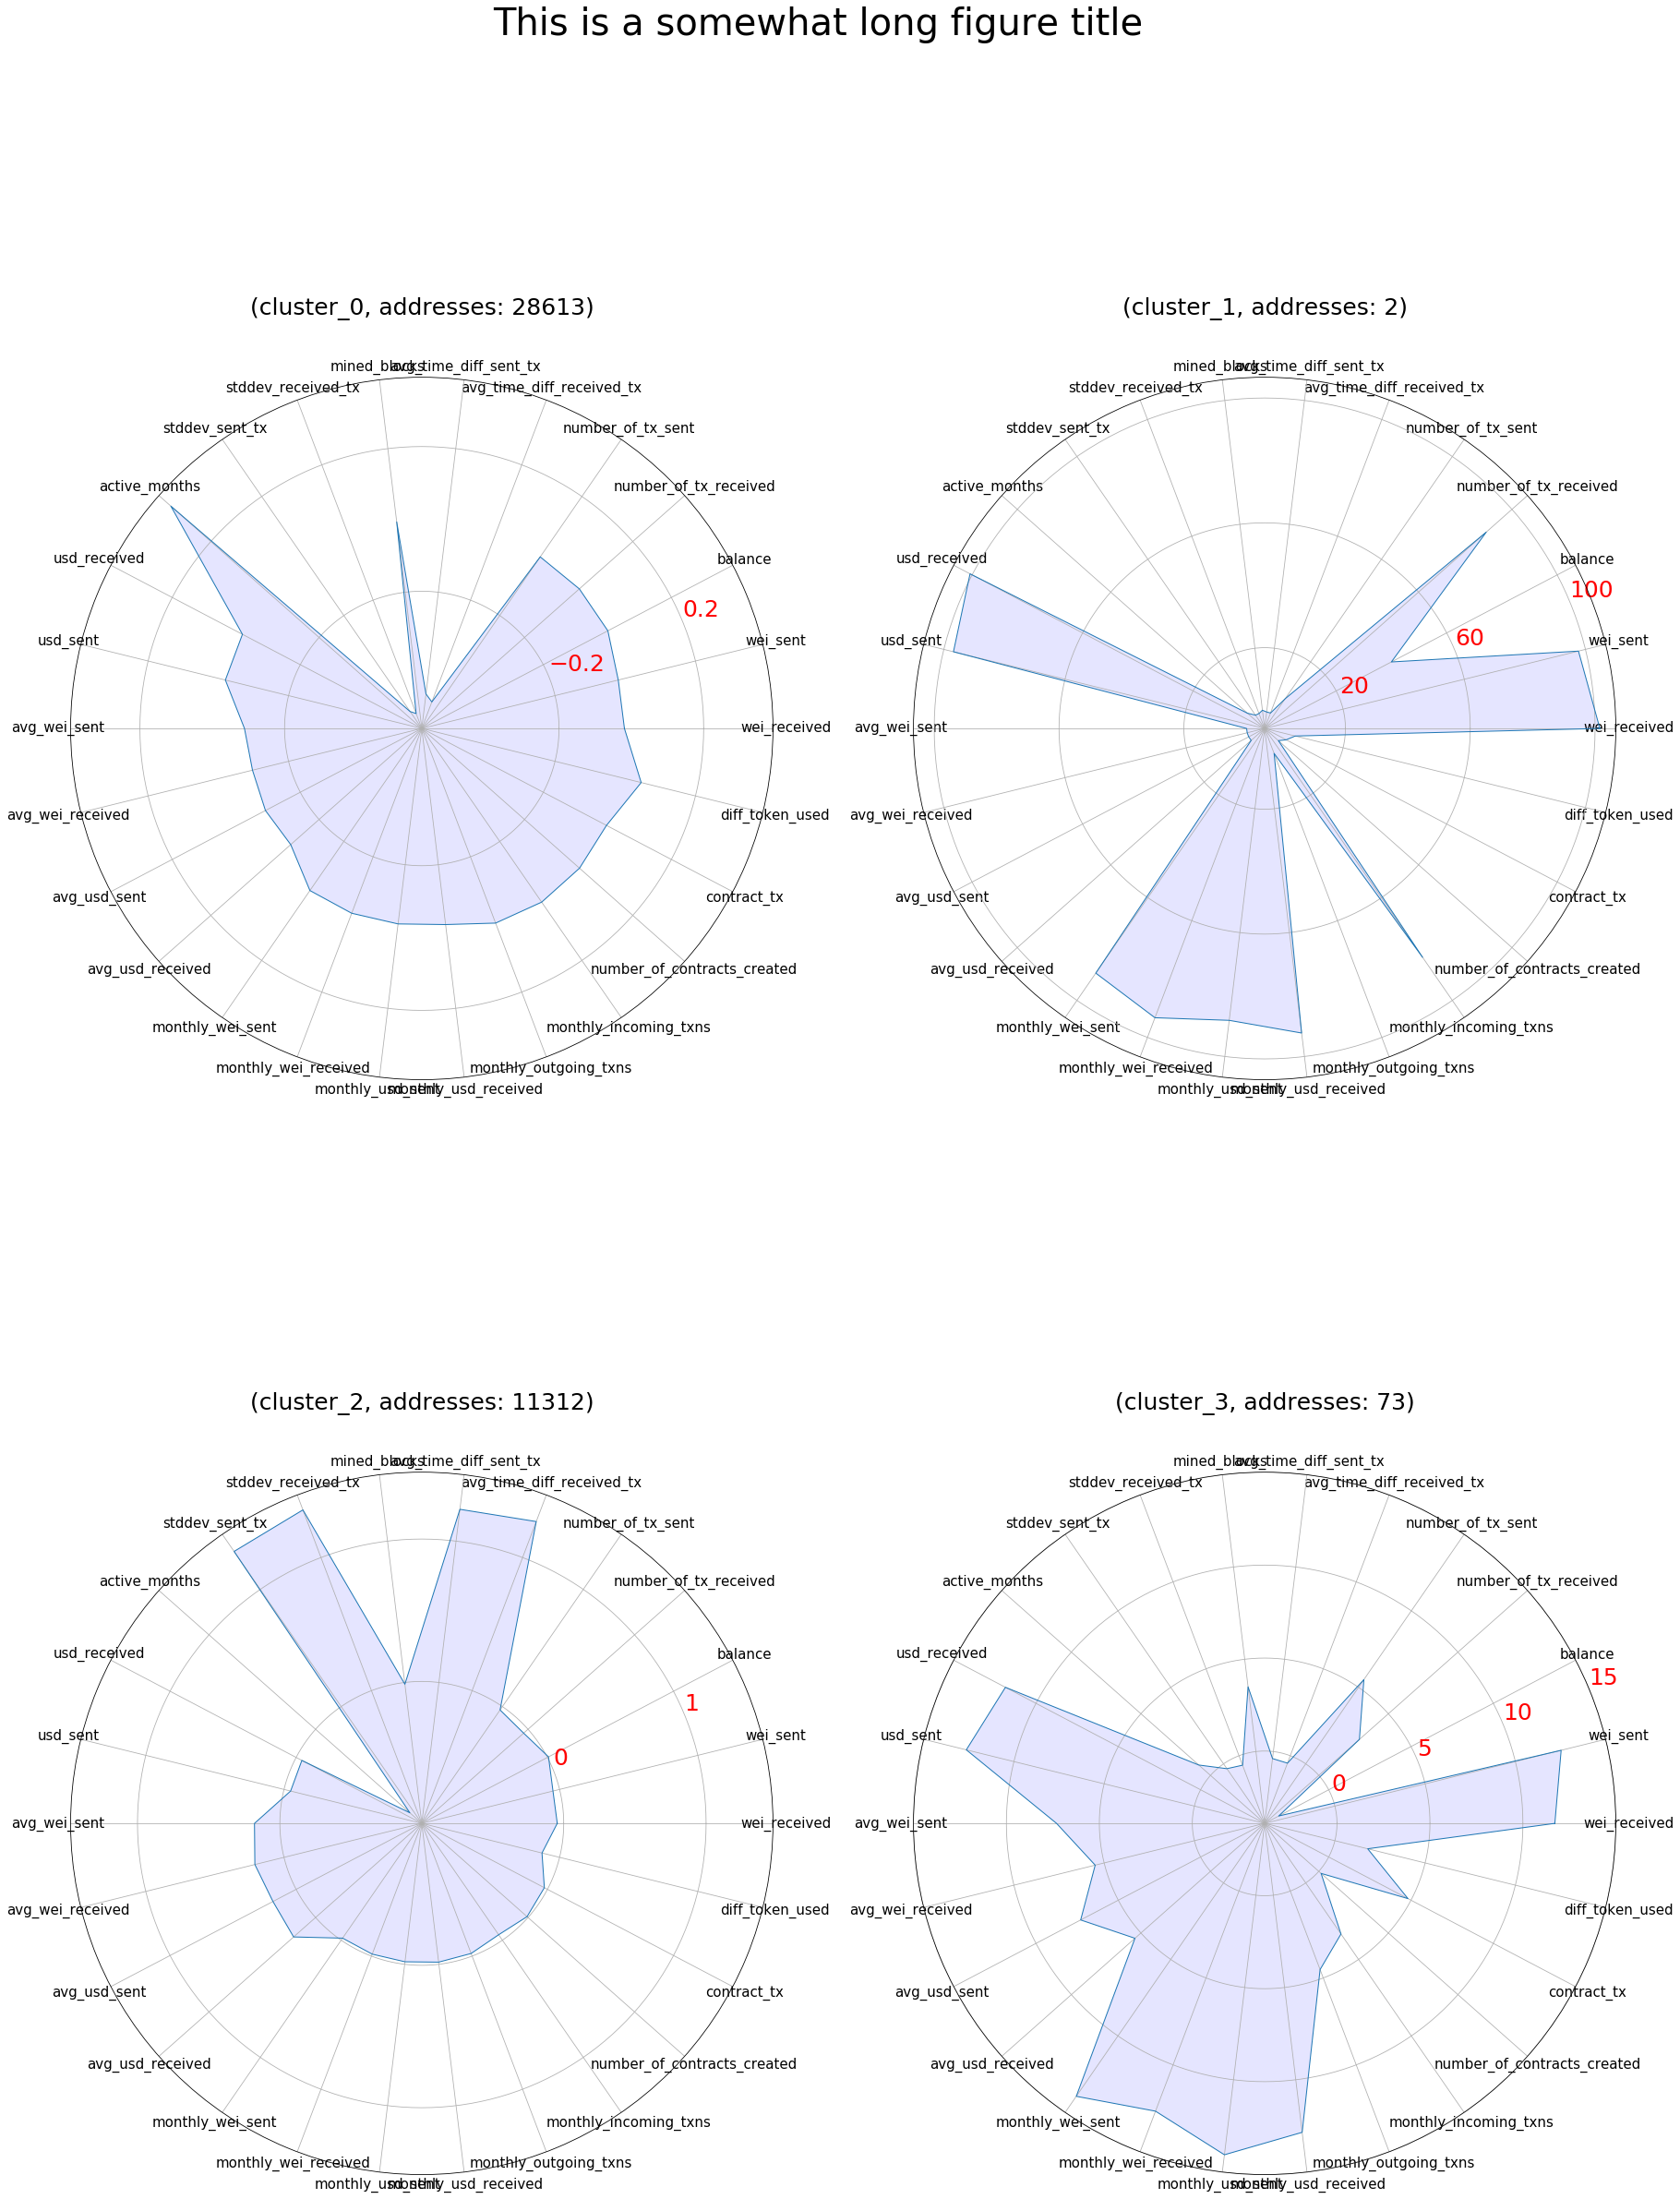

In [166]:
from math import pi
N = len(feature_means.columns)

values = {}
feature_std_means = pd.DataFrame(columns=features.columns[:-1])

for label in labels:
    features_in_cluster = features_std[features["label"] == label]
    feature_means_tmp = features_in_cluster.mean()
    feature_means_tmp.name = 'cluster_{}'.format(label)
    feature_std_means = feature_std_means.append(feature_means_tmp)

for i,v in feature_std_means.iterrows(): 
    tmp_values = feature_std_means.loc[i].values.tolist()
    tmp_values += tmp_values[:1]
    values[i] = tmp_values
    
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig = plt.figure(figsize=(30,40))
fig.suptitle('This is a somewhat long figure title', fontsize=40)

i = 1

for cluster_name, cluster_values in values.items():
    position = int("".join([str(22), str(i)]))
    i += 1
    axis = plt.subplot(position, polar=True)
    plt.sca(axis)
    
    plt.xticks(angles[:-1], features.columns, size=15)
    
    axis.plot(angles, cluster_values, linewidth=1, linestyle='solid')
    axis.fill(angles, cluster_values, 'b', alpha=0.1)
    axis.set_title("({}, addresses: {})".format(cluster_name, clusters[cluster_name]["number_of_addresses"]), color = "black", size=25, loc="center", pad=30)
    plt.yticks([t for i,t in enumerate(axis.get_yticks()) if i%2!=0], size=25, c="red")
    

In [134]:
# from math import pi

# cluster_data_for_plot2 = cluster_data_for_plot1.copy()
# cluster_data_for_plot2 = cluster_data_for_plot2.drop(columns=["cluster_size"])
# cluster_data_for_plot2 = cluster_data_for_plot2.sort_index()
# # cluster_data_for_plot2 = cluster_data_for_plot2.set_index("index")

# categories=list(cluster_data_for_plot2)
# N = len(categories)

# values = {}

# for i,v in cluster_data_for_plot2.iterrows(): 
#     tmp_values = cluster_data_for_plot2.loc[i].values.tolist()
#     tmp_values += tmp_values[:1]
#     values[i] = tmp_values

# angles = [n / float(N) * 2 * pi for n in range(N)]
# angles += angles[:1]
# angles
 
# plt.figure(figsize=(30,40))

# for cluster_label, cluster_values in values.items():
#     position = int("".join([str(33), str(cluster_label + 1)]))
#     axis = plt.subplot(position, polar=True)
#     plt.sca(axis)
#     plt.xticks(angles[:-1], categories, size=15)

# #     plt.ylim(top=1)

#     axis.plot(angles, cluster_values, linewidth=1, linestyle='solid')
#     axis.fill(angles, cluster_values, 'b', alpha=0.1)
# #     a.text(0.1,0.1, cluster_size[i], color = "red", size=20)
#     axis.set_title("Cluster with ID={} has {} addresses".format(cluster_label, cluster_sizes[cluster_label]), color = "black", size=25, loc="center", pad=30)
#     axis.set_yticks([t for i,t in enumerate(axis.get_yticks()) if i%2!=0])

In [135]:
# yticks = axis.get_yticks()
# print(yticks)
# newyticks = [t for i,t in enumerate(yticks) if i%2==0]
# newyticks
# # axis.set_yticks()

In [136]:
# for i,cd in cluster_data.iterrows():a
#     x = features.index[kmeans_opt.labels_==i]
#     print("Length of cluster with id={}: {}".format(i, len(x)))
#     display(x)
#     print("############################")

# Helper functions to analyse data

In [137]:
def open_etherscan(cluster_id, number_of_addresses):
    if len(features.index[kmeans_opt.labels_==cluster_id]) > number_of_addresses:
        for a in np.random.choice(features.index[kmeans_opt.labels_==cluster_id], number_of_addresses):
            webbrowser.open('https://etherscan.io/address/{}'.format(a), new=2)
    else:
        for a in features.index[kmeans_opt.labels_==cluster_id]:
            webbrowser.open('https://etherscan.io/address/{}'.format(a), new=2)
    
open_etherscan(8, 3)

In [138]:
cluster_data

NameError: name 'cluster_data' is not defined

# Recall, Precision und F1 score für das Clustering

In [ ]:
# exchanges = [(a, "e") for i, a in enumerate(features.index) if a.startswith("exchange")]
# speculators = [(a, "x") for i, a in enumerate(features.index) if a.startswith("speculator")]

# exchanges = pd.DataFrame(zip(*exchanges)).T
# speculators = pd.DataFrame(zip(*speculators)).T

# exchanges.columns = ["address", "should_actual_be_in_cluster"]
# speculators.columns = ["address", "should_actual_be_in_cluster"]

# exchanges = exchanges.set_index("address")
# speculators = speculators.set_index("address")

# # features.index[kmeans_opt.labels_ == 2]

# tmp = pd.DataFrame(zip(features.index, kmeans_opt.labels_), columns=["address", "is_in_cluster"])
# tmp = tmp.set_index("address")

# tmp1 = exchanges.append(speculators)

# tmp1 = tmp1.join(tmp, on="address", how="inner")

# cluster_list = []
# for i in tmp1["is_in_cluster"].unique():
#     cluster_list.append(list(tmp1[tmp1["is_in_cluster"] == i]["should_actual_be_in_cluster"]))



In [ ]:
# import collections as collections
# from math import factorial as fac

# def b(x, y):
#     try:
#         binom = fac(x) // fac(y) // fac(x - y)
#     except ValueError:
#         binom = 0
#     return binom

# Counter = collections.Counter

# num_doc= 0
# TP = 0
# FP = 0
# FN = 0
# TN = 0
# c_list = []
# for c in range(0, len(cluster_list)): 
#     # calculating num_doc count...
#     num_doc += len(cluster_list[c])

#     c = Counter(cluster_list[c])
#     c_list.append(c)
#     TP += b(c["e"], 2) 
    
# # Calculate False Positives
    
# for c in range(0, len(cluster_list)): 
#     c = Counter(cluster_list[c])
#     FP += c["e"] * c["x"]

# # Add all the cluster together
# sum = Counter()
# for c in c_list:
#     sum += c

# # calculating FN...
# for ct in c_list:
#     fn_temp = 0 

#     fn_temp += ct["e"]*(sum["e"]-ct["e"])
#     sum -= ct
#     FN += fn_temp


# print("num_doc is %d " % num_doc)
# print("TP is %d " % TP)
# print("FP is %d " % FP)
# print("FN is %d " % FN)
# print("TN is %d " % TN)

# Precision = TP/(TP+FP)
# print("Precision is %.2f " % Precision)

# Recall = TP/(TP+FN)
# print("Recall is %.2f " % Recall)

# F1=(2*Recall*Precision)/(Recall+Precision)
# print("F1 is %.2f " % F1)



In [ ]:
# fig, ax = plt.subplots(figsize= (20,10))

# cluster_list.sort(key=len, reverse = True)
# ind = range(0, len(cluster_list))

# numberOfExchanges = [Counter(cl)["e"] for cl in cluster_list]
# numberOfSpeculators = [Counter(cl)["x"] for cl in cluster_list]

# line1 = ax.barh(ind, numberOfExchanges)
# line2 = ax.barh(ind, numberOfSpeculators, left=numberOfExchanges)

# yticklabels = ax.get_yticklabels()

# start, end = ax.get_ylim()
# ax.set_ylim(-1,7)

# ax.yaxis.set_ticks(np.arange(0, 7, 1))

# ax.legend((line1, line2), ('Exchanges', 'Unkown'), loc="upper right", fontsize="larger")

# yticklabels = ax.set_yticklabels(ind)

# ax.tick_params(
#     which="major",
#     axis='both', 
#     labelsize=13
#     ) 
# ylabel = ax.set_ylabel("Cluster-ID", fontsize="xx-large", rotation=0, labelpad=60)
# ylabel = ax.set_xlabel("Number of features.index", fontsize="xx-large", rotation=0, labelpad=30)


# Temporary stuff

In [ ]:
# import collections as collections

# Counter = collections.Counter

# cluster_list = [['a','a','a','a','a','b'],['a','b','b','b','b','c'],['a','a','c','c','c']]
# num_doc= 0
# positives = 0
# negatives = 0
# TP = 0
# FP = 0
# FN = 0
# TN = 0
# c_list = []
# for c in range(0, len(cluster_list)): 
#     # calculating num_doc count...
#     num_doc += len(cluster_list[c])

#     # calculating positives...
#     positives +=  (len(cluster_list[c])*(len(cluster_list[c])-1))/2

#     # calculating TP...
#     c = Counter(cluster_list[c])
#     c_list.append(c)
#     tp_temp = 0 
#     for k,v in dict(c).items():
#         if v>1:
#             tp_temp += (v*(v-1))/2
#     TP += tp_temp 

# FP = positives - TP
# negatives = ((num_doc*(num_doc-1))/2) - positives
# # Add all the cluster together
# sum = Counter()

# for c in c_list:
#     sum += c

# # calculating FN...
# for ct in c_list:
#     fn_temp = 0 
#     for k,v in dict(ct).items():
#         fn_temp += v*(sum[k]-v)
#     sum -= ct
#     FN += fn_temp
# TN = negatives -FN
# print("num_doc is %d " % num_doc)
# print("positives is %d " % positives)
# print("TP is %d " % TP)
# print("FP is %d " % FP)
# print("FN is %d " % FN)
# print("TN is %d " % TN)

# Precision = TP/(TP+FP)
# print("Precision is %.2f " % Precision)

# Recall = TP/(TP+FN)
# print("Recall is %.2f " % Recall)

# F1=(2*Recall*Precision)/(Recall+Precision)
# print("F1 is %.2f " % F1)

Problem: Mit dem obigen Algorithmus wird die Güte des Clustering Algorithmus ingesamt bestimmt. Ich will aber nur die Güte des Clustering Modell anhand der Exchange Adressen bestimme.

Lösung?: (#Paare im selben cluster) / (#Paare in unterschiedlichen Clustern)

In [ ]:
# import collections as collections

# Counter = collections.Counter

# cluster_list = [['a','a','a','a','a','b'],['a','b','b','b','b','c'],['a','a','c','c','c']]
# num_doc= 0
# positives = 0
# negatives = 0
# TP = 0
# FP = 0
# FN = 0
# TN = 0
# c_list = []
# for c in range(0, len(cluster_list)): 
#     # calculating num_doc count...
#     num_doc += len(cluster_list[c])

#     # calculating positives...
#     positives +=  (len(cluster_list[c])*(len(cluster_list[c])-1))/2

#     # calculating TP...
#     c = Counter(cluster_list[c])
#     c_list.append(c)
#     tp_temp = 0 
#     for k,v in dict(c).items():
#         if v>1:
#             tp_temp += (v*(v-1))/2
#     TP += tp_temp 

# FP = positives - TP
# negatives = ((num_doc*(num_doc-1))/2) - positives
# # Add all the cluster together
# sum = Counter()

# for c in c_list:
#     sum += c

# # calculating FN...
# for ct in c_list:
#     fn_temp = 0 
#     for k,v in dict(ct).items():
#         fn_temp += v*(sum[k]-v)
#     sum -= ct
#     FN += fn_temp
# TN = negatives -FN
# print("num_doc is %d " % num_doc)
# print("positives is %d " % positives)
# print("TP is %d " % TP)
# print("FP is %d " % FP)
# print("FN is %d " % FN)
# print("TN is %d " % TN)

# Precision = TP/(TP+FP)
# print("Precision is %.2f " % Precision)

# Recall = TP/(TP+FN)
# print("Recall is %.2f " % Recall)

# F1=(2*Recall*Precision)/(Recall+Precision)
# print("F1 is %.2f " % F1)